# BUSINESS SCIENCE, CAUSAL INFERENCE IN PYTHON, SOLUTION: REDUCE HOTEL CANCELLATION

## Goals:
- We have develiped an experiment: Send a targeted offer to customers in Market Segment == "Groups" who book more than 90 days out
- Offer 10% off (on average $1500 this costs hotel $150)
- The population is 19811 customers over the period analyzed
- The test population is 500 customers (250 control, 250 treatment)

## Questions:
- What affect does this have on cancellations?
- Is there a Return on Investment (ROI)?

## Important:
- This is a scenario that is post-treatment data analysis

In [1]:
import pandas as pd
import numpy as np
import pytimetk as tk
import matplotlib.pyplot as plt

from causalml.inference.tree import UpliftTreeClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot
from causalml.inference.meta import BaseSClassifier, BaseTClassifier

from IPython.display import Image
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

Failed to import duecredit due to No module named 'duecredit'


In [2]:
hotel_cancelation_raw_df = pd.read_csv('D:\Kerja\Merkle\causalml\hands_on\dataset\hotel_bookings.csv\hotel_bookings.csv')

In [3]:
# 1. Basic Feature Engineering
hotel_cancellations_df = hotel_cancelation_raw_df.copy()
hotel_cancellations_df = hotel_cancellations_df[hotel_cancellations_df['market_segment'] == 'Groups']

# Adding new features
hotel_cancellations_df['total_stay'] = hotel_cancellations_df['stays_in_weekend_nights'] + hotel_cancellations_df['stays_in_week_nights']
hotel_cancellations_df['total_guests'] = hotel_cancellations_df['adults'] + hotel_cancellations_df['children'] + hotel_cancellations_df['babies']
hotel_cancellations_df['different_room_assigned'] = (hotel_cancellations_df['reserved_room_type']!= hotel_cancellations_df['assigned_room_type']).astype(int)
hotel_cancellations_df['country'].fillna('PRT')
hotel_cancellations_df['country_PRT']=(hotel_cancellations_df['country']=='PRT').astype(int)
hotel_cancellations_df['country_other']=(hotel_cancellations_df['country']!='PRT').astype(int)
hotel_cancellations_groups = hotel_cancellations_df.copy()
hotel_cancellations_groups = hotel_cancellations_groups.sample(500, random_state=123)
hotel_cancellations_groups['treatment_control'] = np.random.permutation(['control']*250 + ['treatment']*250)

In [4]:
# Create the 'accept_offer' column based on 'treatment_control'
def assign_accept_offer(row):
    if row['treatment_control'] == 'treatment':
        return np.random.randint(2)  # Randomly assign 0 or 1
    else:
        return 0

hotel_cancellations_groups['accept_offer'] = hotel_cancellations_groups.apply(assign_accept_offer, axis=1)

In [5]:
def assign_new_lead_time(row):
    if row['treatment_control'] == 'treatment' and row['accept_offer']==1:
        return np.random.randint(18, 80)
    else:
        return row['lead_time']

hotel_cancellations_groups['new_lead_time'] = hotel_cancellations_groups.apply(assign_new_lead_time, axis=1)

In [6]:
hotel_cancellations_groups.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,reservation_status,reservation_status_date,total_stay,total_guests,different_room_assigned,country_PRT,country_other,treatment_control,accept_offer,new_lead_time
10475,Resort Hotel,1,86,2017,March,10,9,0,3,2,...,Canceled,2016-12-13,3,2.0,0,1,0,treatment,1,32
74077,City Hotel,1,321,2015,September,36,3,0,2,2,...,Canceled,2015-01-01,2,2.0,0,1,0,control,0,321
68215,City Hotel,1,104,2017,May,20,15,1,2,1,...,Canceled,2017-01-31,3,1.0,0,1,0,treatment,0,104
29215,Resort Hotel,0,36,2016,October,43,20,0,3,2,...,Check-Out,2016-10-23,3,2.0,0,0,1,control,0,36
36738,Resort Hotel,0,388,2017,May,21,25,0,3,2,...,Check-Out,2017-05-28,3,2.0,0,0,1,treatment,0,388


### 1.0 EXPERIMENT ANALYSIS

In [7]:
hotel_experiment_df = hotel_cancellations_groups[['is_canceled', 'deposit_type', 'previous_cancellations',
                                             'lead_time', 'total_of_special_requests', 'different_room_assigned',
                                             'market_segment', 'required_car_parking_spaces', 'distribution_channel',
                                             'hotel', 'customer_type', 'previous_bookings_not_canceled',
                                             'is_repeated_guest', 'country_PRT', 'country_other', 
                                             'treatment_control','accept_offer', 'new_lead_time']]

In [8]:
hotel_experiment_df.head()

,is_canceled,deposit_type,previous_cancellations,lead_time,total_of_special_requests,different_room_assigned,market_segment,required_car_parking_spaces,distribution_channel,hotel,customer_type,previous_bookings_not_canceled,is_repeated_guest,country_PRT,country_other,treatment_control,accept_offer,new_lead_time
10475,1,Non Refund,0,86,0,0,Groups,0,TA/TO,Resort Hotel,Transient,0,0,1,0,treatment,1,32
74077,1,Non Refund,1,321,0,0,Groups,0,TA/TO,City Hotel,Contract,0,0,1,0,control,0,321
68215,1,Non Refund,0,104,0,0,Groups,0,TA/TO,City Hotel,Transient,0,0,1,0,treatment,0,104
29215,0,No Deposit,0,36,0,0,Groups,0,Corporate,Resort Hotel,Transient-Party,0,0,0,1,control,0,36
36738,0,No Deposit,0,388,1,0,Groups,0,TA/TO,Resort Hotel,Transient-Party,0,0,0,1,treatment,0,388


In [9]:
hotel_experiment_df.glimpse()

<class 'pandas.core.frame.DataFrame'>: 500 rows of 18 columns
is_canceled:                     int64             [1, 1, 1, 0, 0, 0, 1, ...
deposit_type:                    object            ['Non Refund', 'Non R ...
previous_cancellations:          int64             [0, 1, 0, 0, 0, 0, 0, ...
lead_time:                       int64             [86, 321, 104, 36, 38 ...
total_of_special_requests:       int64             [0, 0, 0, 0, 1, 0, 0, ...
different_room_assigned:         int32             [0, 0, 0, 0, 0, 0, 0, ...
market_segment:                  object            ['Groups', 'Groups',  ...
required_car_parking_spaces:     int64             [0, 0, 0, 0, 0, 1, 0, ...
distribution_channel:            object            ['TA/TO', 'TA/TO', 'T ...
hotel:                           object            ['Resort Hotel', 'Cit ...
customer_type:                   object            ['Transient', 'Contra ...
previous_bookings_not_canceled:  int64             [0, 0, 0, 0, 0, 0, 0, ...
is_repeated_gu

In [10]:
# How many people receive offers to rebook at a earlier date?
df = hotel_experiment_df.copy()
df['treatment_control'].value_counts()

treatment_control
treatment    250
control      250
Name: count, dtype: int64

In [11]:
# How many people accepted the offer?
print(df.groupby('treatment_control')['accept_offer'].sum())

df.groupby('treatment_control')['accept_offer'] \
    .agg(['sum','count']) \
    .assign(acceptance_rate=lambda x: x['sum']/x['count'])

treatment_control
control        0
treatment    124
Name: accept_offer, dtype: int64


,sum,count,acceptance_rate
treatment_control,,,
control,0,250,0.000
treatment,124,250,0.496


In [12]:
# What is the average cancellation rate for each group?
df \
    .groupby('treatment_control')['is_canceled'] \
    .agg(['sum', 'count']) \
    .assign(cancellation_rate=lambda x: x['sum']/ x['count'])

,sum,count,cancellation_rate
treatment_control,,,
control,145,250,0.58
treatment,150,250,0.60


In [13]:
# Of the people who accepted the offer, what is their cancellation rate?
df \
    .groupby(['treatment_control', 'accept_offer']) \
    ['is_canceled'] \
    .agg(['sum', 'count']) \
    .assign(cancellation_rate = lambda x: x['sum'] / x['count'])

sum  count  cancellation_rate
treatment_control accept_offer                               
control           0             145    250           0.580000
treatment         0              76    126           0.603175
                  1              74    124           0.596774

### 2.0 CAUSAL MACHINE LEARNING ANALYSIS

In [14]:
# Prep
df = hotel_experiment_df.copy()
df['conversion'] = (~ df['is_canceled'].astype(bool)).astype(int)

In [15]:
df.drop(columns=['is_canceled', 'accept_offer', 'lead_time'], inplace=True)

In [16]:
df.glimpse()

<class 'pandas.core.frame.DataFrame'>: 500 rows of 16 columns
deposit_type:                    object            ['Non Refund', 'Non R ...
previous_cancellations:          int64             [0, 1, 0, 0, 0, 0, 0, ...
total_of_special_requests:       int64             [0, 0, 0, 0, 1, 0, 0, ...
different_room_assigned:         int32             [0, 0, 0, 0, 0, 0, 0, ...
market_segment:                  object            ['Groups', 'Groups',  ...
required_car_parking_spaces:     int64             [0, 0, 0, 0, 0, 1, 0, ...
distribution_channel:            object            ['TA/TO', 'TA/TO', 'T ...
hotel:                           object            ['Resort Hotel', 'Cit ...
customer_type:                   object            ['Transient', 'Contra ...
previous_bookings_not_canceled:  int64             [0, 0, 0, 0, 0, 0, 0, ...
is_repeated_guest:               int64             [0, 0, 0, 0, 0, 0, 0, ...
country_PRT:                     int32             [1, 1, 1, 0, 0, 0, 1, ...
country_other:

In [17]:
df_processed = pd.get_dummies(
    df,
    columns=['deposit_type', 'market_segment', 'distribution_channel', 'hotel', 'customer_type'],
    drop_first=False,
    dtype=int
)

df_processed.glimpse()

<class 'pandas.core.frame.DataFrame'>: 500 rows of 23 columns
previous_cancellations:          int64             [0, 1, 0, 0, 0, 0, 0, ...
total_of_special_requests:       int64             [0, 0, 0, 0, 1, 0, 0, ...
different_room_assigned:         int32             [0, 0, 0, 0, 0, 0, 0, ...
required_car_parking_spaces:     int64             [0, 0, 0, 0, 0, 1, 0, ...
previous_bookings_not_canceled:  int64             [0, 0, 0, 0, 0, 0, 0, ...
is_repeated_guest:               int64             [0, 0, 0, 0, 0, 0, 0, ...
country_PRT:                     int32             [1, 1, 1, 0, 0, 0, 1, ...
country_other:                   int32             [0, 0, 0, 1, 1, 1, 0, ...
treatment_control:               object            ['treatment', 'contro ...
new_lead_time:                   int64             [32, 321, 104, 36, 38 ...
conversion:                      int32             [0, 0, 0, 1, 1, 1, 0, ...
deposit_type_No Deposit:         int32             [0, 0, 0, 1, 1, 0, 0, ...
deposit_type_N

#### Uplift Tree
https://causalml.readthedocs.io/en/latest/methodology.html#uplift-tree

In [18]:
# Split data to training and testing samples for model validation (next section)
df_train, df_test = train_test_split(df_processed, test_size=0.2, random_state=111)

In [19]:
# Train uplift tree
uplift_model = UpliftTreeClassifier(max_depth=4, 
                                    min_samples_leaf=200, 
                                    min_samples_treatment=50, 
                                    n_reg=100, 
                                    evaluationFunction='KL', 
                                    control_name='control')

In [20]:
# Specify columns to be used for training
x_names = ['previous_cancellations', 'total_of_special_requests', 'different_room_assigned', 'required_car_parking_spaces',
       'previous_bookings_not_canceled', 'is_repeated_guest', 'country_PRT', 'country_other', 'new_lead_time', 
       'deposit_type_No Deposit', 'deposit_type_Non Refund', 'market_segment_Groups', 'distribution_channel_Corporate', 
       'distribution_channel_Direct', 'distribution_channel_TA/TO', 'hotel_City Hotel', 'hotel_Resort Hotel',
       'customer_type_Contract', 'customer_type_Transient', 'customer_type_Transient-Party']

In [21]:
# Train uplift tree
uplift_model = UpliftTreeClassifier(
    max_depth = 4,
    min_samples_leaf = 20,
    min_samples_treatment = 10,
    n_reg = 0,
    evaluationFunction = 'KL', # The Kullback-Leiber (KL) divergence
    control_name = 'control'
)

In [22]:
uplift_model.fit(df_train[x_names].values,
                 treatment = df_train['treatment_control'].values,
                 y=df_train['conversion'].values)

In [23]:
# Print uplift tree as a string
result = uplift_tree_string(uplift_model.fitted_uplift_tree, x_names)

new_lead_time >= 60.39999999999998?
yes -> country_PRT >= 0.1?
		yes -> hotel_City Hotel >= 0.1?
				yes -> [0.0625, 0.12]
				no  -> [0.08695652173913043, 0.2631578947368421]
		no  -> new_lead_time >= 183.0?
				yes -> [0.95, 0.8571428571428571]
				no  -> [0.9411764705882353, 1.0]
no  -> country_PRT >= 0.1?
		yes -> [0.4375, 0.19607843137254902]
		no  -> [1.0, 0.9259259259259259]


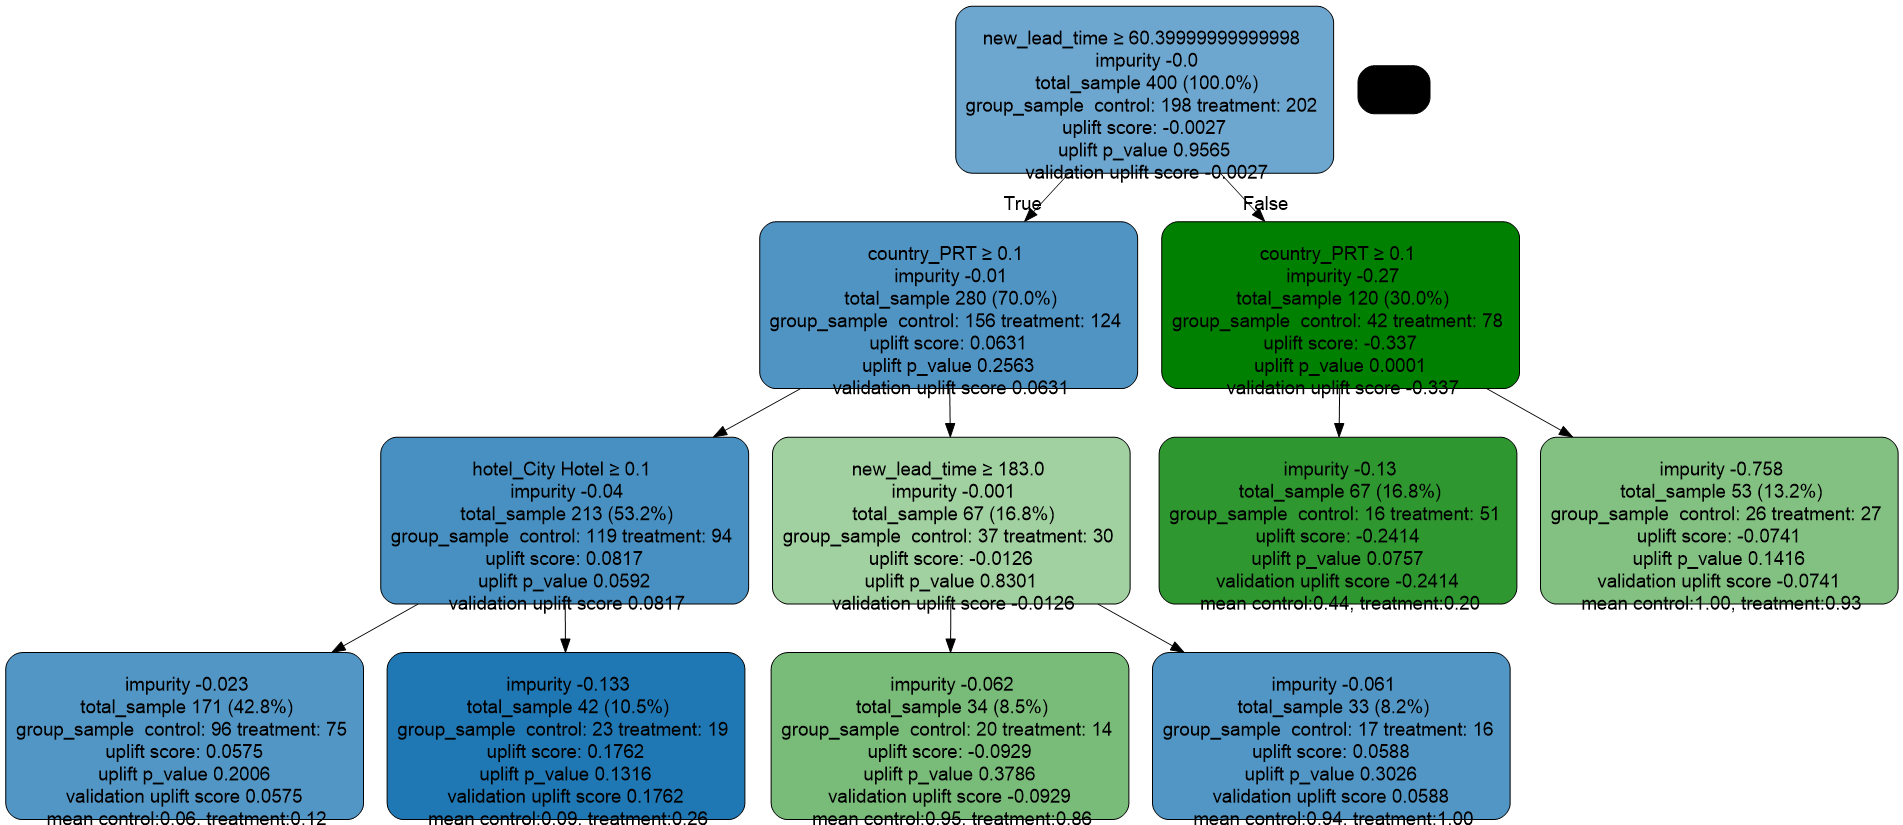

In [24]:
# Plot uplift tree
graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, x_names)
Image(graph.create_png())

An uplift tree is a type of decision tree model that is specifically designed to identify subgroups of individuals who are likely to respond positively (or negatively) to a particular treatment or intervention. The goal is to target the treatment or intervention to those individuals who are most likely to benefit from it, thereby maximizing the overall uplift or treatment effect.

Let's consider a simple example of an uplift tree for a marketing campaign. Suppose a company wants to promote a new product and wants to identify the customers who are most likely to respond positively to a direct mail campaign.

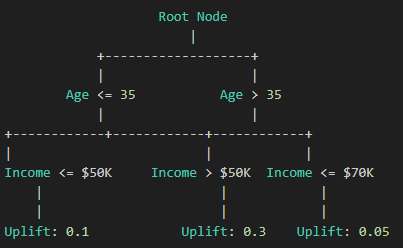

Here's how you can interpret this uplift tree:

1. The root node represents the entire population of customers.
2. The first split is based on the customer's age. Customers aged 35 or younger go to the left branch, while customers older than 35 go to the right branch.
3. For customers aged 35 or younger, there is another split based on their income. Customers with an income of $50K or less go to the left leaf node, while customers with an income greater than $50K go to the right leaf node.
4. For customers older than 35, there is a split based on their income as well. Customers with an income of $70K or less go to the left leaf node.
5. Each leaf node represents a subgroup of customers and has an associated "uplift" value. This value represents the estimated increase in the response rate (or any other desired outcome) if the treatment (e.g., direct mail campaign) is applied to that subgroup.
6. In this example, the uplift tree suggests that the direct mail campaign should be targeted towards customers who are older than 35 and have an income greater than $50K, as this subgroup has the highest estimated uplift of 0.3 (or 30%).

The uplift tree provides a simple and interpretable way to identify the subgroups of individuals who are most likely to respond positively to a treatment or intervention, allowing for more effective targeting and resource allocation.

<Axes: >

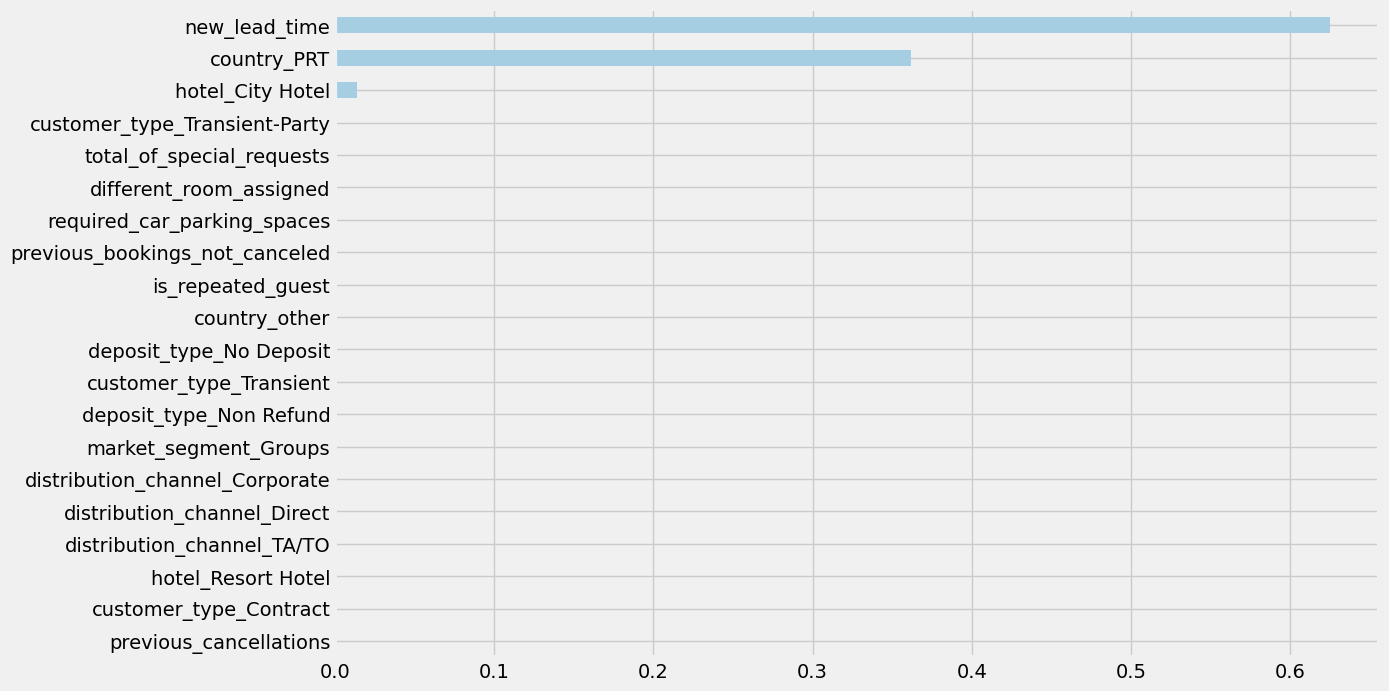

In [25]:
# Uplift Tree Importances (Interpretable CausalML)
pd.Series(uplift_model.feature_importances_, index=x_names).sort_values().plot(kind='barh', figsize=(12,8))

### INTERPRETABLE CAUSAL ML
https://causalml.readthedocs.io/en/latest/methodology.html#s-learner \
https://causalml.readthedocs.io/en/latest/interpretation.html

In [26]:
slearner = BaseSClassifier(learner=LGBMClassifier(), control_name='control') # Create SClassifier with LGBM as base learner

slearner.estimate_ate(df_train[x_names].values, 
                      df_train['treatment_control'].values,
                      df_train['conversion'].values,
                      return_ci=True)

[LightGBM] [Info] Number of positive: 153, number of negative: 247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141
[LightGBM] [Info] Number of data points in the train set: 400, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.382500 -> initscore=-0.478950
[LightGBM] [Info] Start training from score -0.478950
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

(array([0.01091553]), array([-0.01215114]), array([0.03398219]))

In [27]:
slearner_tau = slearner.fit_predict(df_train[x_names].values,
                                    df_train['treatment_control'].values,
                                    df_train['conversion'].values)

[LightGBM] [Info] Number of positive: 153, number of negative: 247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141
[LightGBM] [Info] Number of data points in the train set: 400, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.382500 -> initscore=-0.478950
[LightGBM] [Info] Start training from score -0.478950
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

In [28]:
# Conditional Average Treatment Effect (CATE, denoted Tau)
slearner_tau

array([[-3.75539072e-03],
       [ 1.97573499e-04],
       [ 9.30925608e-04],
       [ 1.32348203e-04],
       [-4.89357120e-02],
       [-8.39862454e-05],
       [-1.41434468e-03],
       [-1.17535466e-04],
       [-8.20419558e-05],
       [ 9.83631732e-05],
       [ 6.09954745e-03],
       [ 4.82212600e-04],
       [ 4.82212600e-04],
       [ 2.18651007e-04],
       [-7.92352362e-03],
       [ 1.60719725e-02],
       [-1.73260864e-03],
       [-2.44825370e-03],
       [ 4.12186416e-04],
       [-1.30296101e-04],
       [-1.54342251e-04],
       [-5.39619383e-03],
       [-1.32454913e-03],
       [-8.51325056e-04],
       [ 9.51091330e-05],
       [-5.21541458e-05],
       [ 1.85803694e-04],
       [-4.50121122e-03],
       [ 5.04742660e-04],
       [-5.37058954e-05],
       [ 1.11766098e-04],
       [ 4.82212600e-04],
       [ 1.73609726e-04],
       [ 4.82212600e-04],
       [-4.41093178e-04],
       [ 1.40924315e-04],
       [ 9.67958609e-05],
       [-8.39862454e-05],
       [-2.4

What really happen here, it tells us whether treatment has positive or negative impact on each people conversion. let's say the first row (2.74122431e-03) having small positive impact after treatment, but the second row (-2.20427031e-03) have slightly negative impact

In [29]:
slearner.get_importance(X=df_train[x_names].values, tau=slearner_tau, normalize=True, method='auto', features=x_names)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

{'treatment': new_lead_time                     0.558024
 country_PRT                       0.192774
 deposit_type_No Deposit           0.090891
 customer_type_Transient-Party     0.069321
 customer_type_Transient           0.047981
 previous_cancellations            0.018584
 hotel_City Hotel                  0.009638
 deposit_type_Non Refund           0.006531
 different_room_assigned           0.004355
 total_of_special_requests         0.000826
 distribution_channel_TA/TO        0.000624
 distribution_channel_Direct       0.000420
 distribution_channel_Corporate    0.000031
 is_repeated_guest                 0.000000
 country_other                     0.000000
 previous_bookings_not_canceled    0.000000
 required_car_parking_spaces       0.000000
 market_segment_Groups             0.000000
 hotel_Resort Hotel                0.000000
 customer_type_Contract            0.000000
 dtype: float64}

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

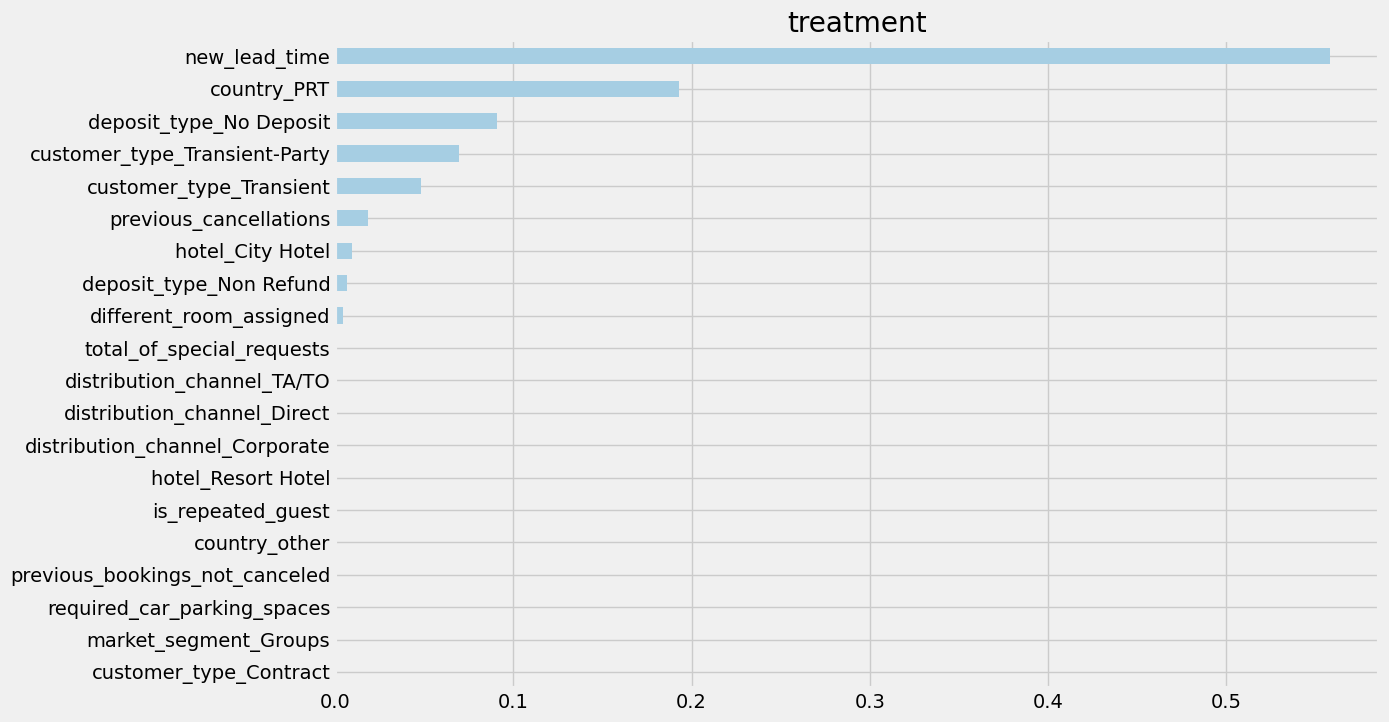

In [30]:
slearner.plot_importance(X=df_train[x_names].values, tau=slearner_tau, normalize=True, method='auto', features=x_names)

In [31]:
slearner.get_shap_values(X=df_train[x_names].values, tau = slearner_tau)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

{'treatment': array([[ 0.00164764, -0.00077022, -0.01283953, ...,  0.        ,
         -0.00438269, -0.00323232],
        [ 0.00160146, -0.00070219,  0.00134426, ...,  0.        ,
         -0.00767818, -0.01231163],
        [ 0.00270872, -0.0006699 ,  0.00145704, ...,  0.        ,
         -0.01444301, -0.01179247],
        ...,
        [ 0.00896948, -0.00054936,  0.00210712, ...,  0.        ,
          0.00599771,  0.01444358],
        [ 0.00928222, -0.00042356,  0.00285883, ...,  0.        ,
          0.00939524,  0.00522218],
        [-0.02968862, -0.00039839,  0.00055189, ...,  0.        ,
          0.00589736, -0.00376106]])}

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

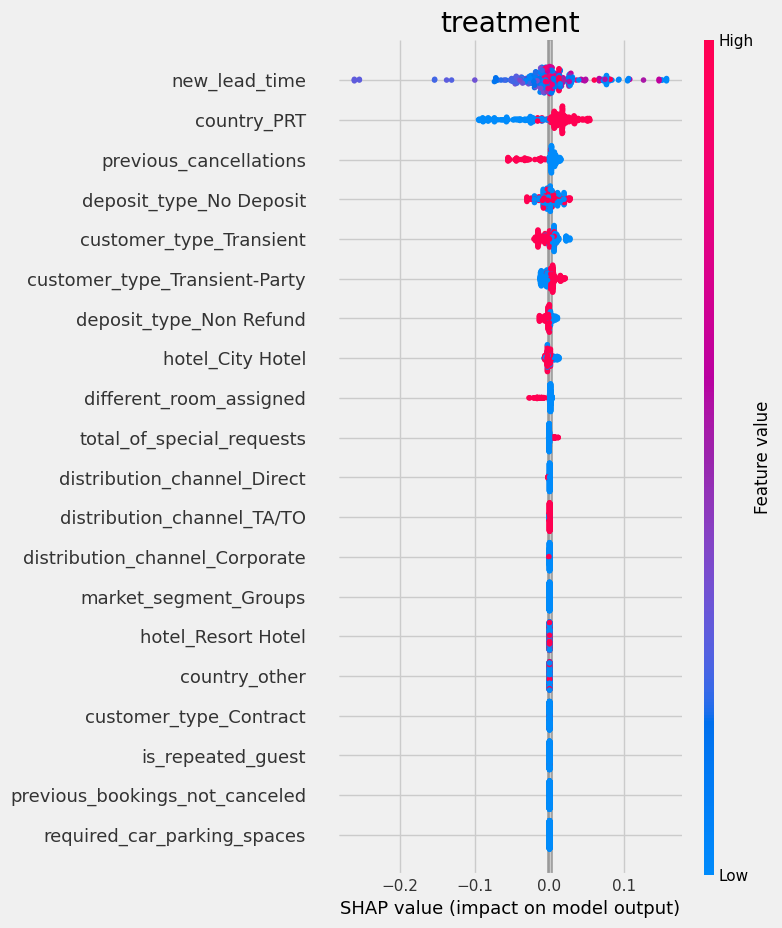

In [32]:
slearner.plot_shap_values(X=df_train[x_names].values, tau = slearner_tau, features=x_names)

In [33]:
x_names

['previous_cancellations',
 'total_of_special_requests',
 'different_room_assigned',
 'required_car_parking_spaces',
 'previous_bookings_not_canceled',
 'is_repeated_guest',
 'country_PRT',
 'country_other',
 'new_lead_time',
 'deposit_type_No Deposit',
 'deposit_type_Non Refund',
 'market_segment_Groups',
 'distribution_channel_Corporate',
 'distribution_channel_Direct',
 'distribution_channel_TA/TO',
 'hotel_City Hotel',
 'hotel_Resort Hotel',
 'customer_type_Contract',
 'customer_type_Transient',
 'customer_type_Transient-Party']

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

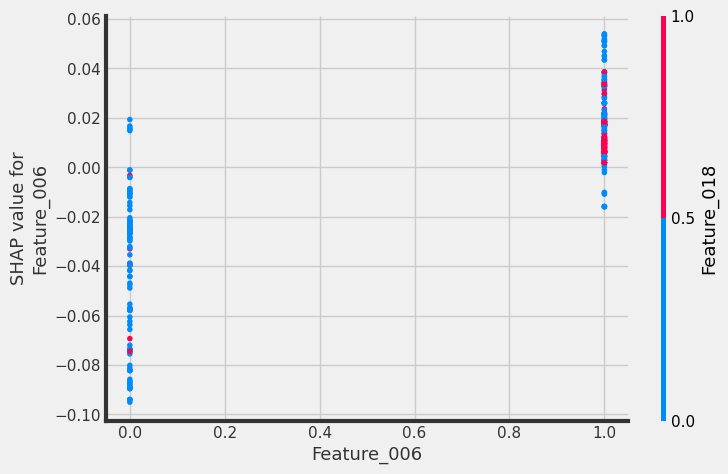

In [34]:
# country_PRT (Index 6)
slearner.plot_shap_dependence(treatment_group='treatment', feature_idx=6, X=df_train[x_names].values, tau = slearner_tau, interaction_idx='auto')

This chart is a SHAP (SHapley Additive exPlanations) dependence plot. It helps us understand the relationship between a specific feature (in this case, Feature_006) and the predicted outcome (Feature_010), while taking into account the interaction effects with another feature.

Here’s a simple interpretation:

1. Horizontal Axis (Feature_006): This represents the values of Feature_006. In your case, it ranges from 0.0 to 1.0.
2. Vertical Axis (SHAP value for Feature_010): This represents the impact of Feature_006 on the prediction of Feature_010. The SHAP value can be positive (increasing the prediction) or negative (decreasing the prediction). In your case, it ranges from approximately -0.05 to 0.15.
3. Color Gradient: The color of each point represents the value of another feature that has the most interaction effect with Feature_006. The color scale goes from blue (low values) to red (high values).

From the plot, we can observe that:

- Most of the data points are concentrated at Feature_006 = 1.0. This suggests that Feature_006 has a significant impact on Feature_010 when it is at its maximum value.
- The SHAP values vary widely when Feature_006 = 1.0, indicating that the impact of Feature_006 on Feature_010 is not constant but depends on the values of other features (indicated by the color gradient).

In summary, this plot provides a visual way to understand the complex relationships and interactions between features in your machine learning model. It shows how Feature_006 influences the prediction of Feature_010, and how this influence changes with different values of Feature_006 and other interacting features. It’s a powerful tool for interpreting the predictions of complex models.

So lets say, when the group is from Portugal, most of it has deposit_type_non_refund set to false, which mean they want their deposit to be refunded.

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

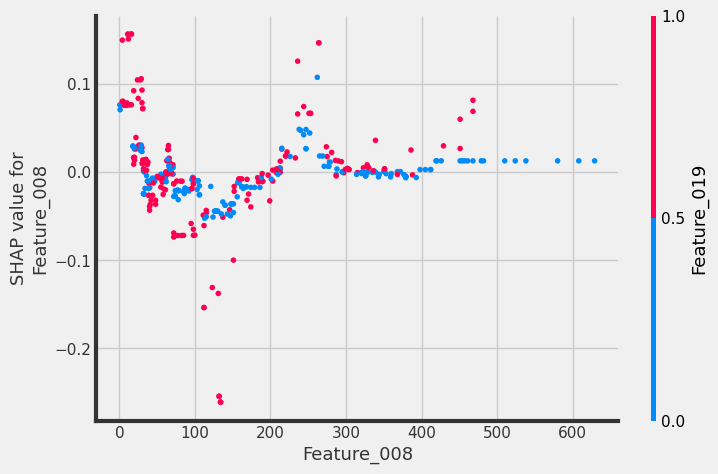

In [35]:
# New Lead Time (Index 8)
slearner.plot_shap_dependence(treatment_group='treatment', feature_idx=8, X=df_train[x_names].values, tau = slearner_tau, interaction_idx='auto')

and here, the new lead time shows, lets say below 100 days of lead time, most of the groups are deposit_type_No Deposit set to true, which mean they do not pay for deposit, It is understandable, since deposit is more likely for safety if the groups cancel their booking, and if the lead time relatively short, they dont want to pay

### OPTIMIZE FOR CONVERSION
https://github.com/uber/causalml/blob/master/docs/examples/counterfactual_value_optimization.ipynb

In [36]:
from causalml.inference.meta import BaseTClassifier
from causalml.optimize import get_treatment_costs
from causalml.optimize import get_actual_value

In [37]:
# Put costs into dicts
conversion_cost_dict = {'control':0, 'treatment':150} # Since we discount $150 when conversion happen
impression_cost_dict = {'control':0, 'treatment':0}

In [38]:
# Use a helper function to put treatment costs to array
cc_array, ic_array, conditions = get_treatment_costs(
    treatment=df_processed['treatment_control'],
    control_name = 'control',
    cc_dict = conversion_cost_dict,
    ic_dict = impression_cost_dict
)

In [39]:
# Put the conversion value into an array
conversion_value_array = np.full(df.shape[0], 1500)

In [40]:
# Use a helper function to obtain the value of actual treatment
actual_value = get_actual_value(
    treatment = df_processed['treatment_control'],
    observed_outcome=df_processed['conversion'],
    conversion_value=conversion_value_array,
    conditions=conditions,
    conversion_cost=cc_array,
    impression_cost=ic_array
)

(array([295.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 205.]),
 array([   0.,  150.,  300.,  450.,  600.,  750.,  900., 1050., 1200.,
        1350., 1500.]),
 <BarContainer object of 10 artists>)

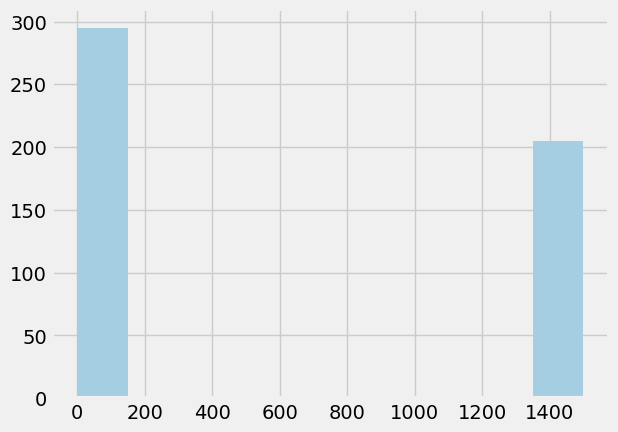

In [41]:
plt.hist(actual_value)

In [42]:
df_train, df_test = train_test_split(df_processed, test_size=0.2, random_state=111)
train_idx = df_train.index
test_idx = df_test.index

In [43]:
# Calculate the benchmark value according to the random allocation and best treatment schemes
# by looking for actual value in which the test_idx resides and then calculate the mean
random_allocation_value = actual_value.loc[test_idx].mean()
random_allocation_value

745.5

In [44]:
# Grouping df_train by treatment control, and then calculate the mean for each treatment control, 
# and then took the max value of the mean for both control and treatment, and decice which one is better
best_ate = df_train.groupby('treatment_control')['conversion'].mean().idxmax()
best_ate

'control'

In [45]:
# Marking the best_ate from df_test
actual_is_best_ate = df_test['treatment_control'] == best_ate
actual_is_best_ate

82827    False
5838     False
35174    False
87552    False
10345    False
         ...  
81031    False
28645     True
70178     True
5819      True
44045     True
Name: treatment_control, Length: 100, dtype: bool

In [46]:
# Calculate the best_ate from actual_value on test_idx, and take the mean value of it
best_ate_value = actual_value.loc[test_idx][actual_is_best_ate].mean()
best_ate_value

836.5384615384615

In [47]:
# Calculate the value under an uplift model
tm = BaseTClassifier(
    control_learner=LGBMClassifier(),
    treatment_learner = LGBMClassifier(),
    control_name = 'control'
)

In [48]:
tm.fit(df_train[x_names].values,
       df_train['treatment_control'],
       df_train['conversion'])

[LightGBM] [Info] Number of positive: 76, number of negative: 122
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 82
[LightGBM] [Info] Number of data points in the train set: 198, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383838 -> initscore=-0.473288
[LightGBM] [Info] Start training from score -0.473288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [49]:
# Predict the uplift score for each person in df_test, positive score indicate giving treatment
# to the person may result in conversion, otherwise for negative score
tm_pred = tm.predict(df_test[x_names].values)

In [50]:
pred_df = pd.DataFrame(tm_pred, columns=tm._classes)

In [51]:
# The weird thing is that all the tm_best is 'treatment', which make me confused since for negative
# result, the value should be 'control' right?
tm_best = pred_df.idxmax(axis=1)

In [52]:
actual_is_tm_best = df_test['treatment_control']==tm_best.ravel()

In [53]:
# again, actual_is_tm_best only consist of treatment in accordance with current treatment given for each person
tm_value = actual_value.loc[test_idx][actual_is_tm_best].mean()
tm_value

646.875

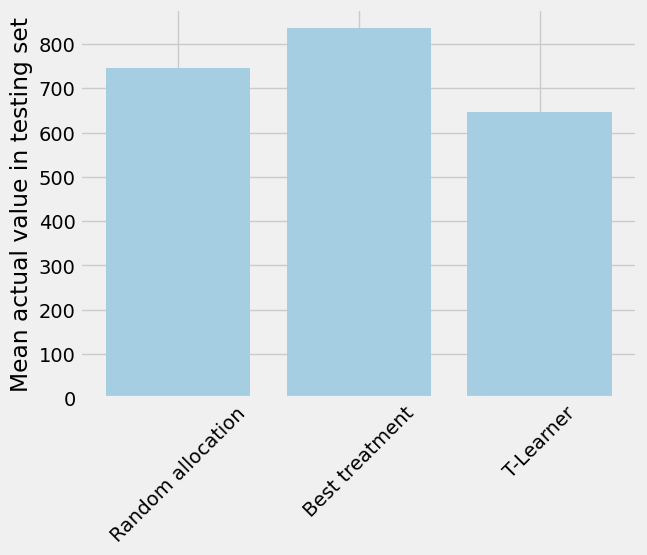

In [54]:
# Plot the results
labels = [
    'Random allocation',
    'Best treatment',
    'T-Learner'
]

values = [
    random_allocation_value,
    best_ate_value,
    tm_value
]

plt.bar(labels, values)
plt.ylabel('Mean actual value in testing set')
plt.xticks(rotation=45)
plt.show()

Roughly, the mean actual value in testing set represent how much we can save for each person, but nonetheless, the author also unsure

### 3.0 UPLIFT: BACK TO BASICS

In [55]:
df = hotel_experiment_df.copy()

In [56]:
# How many people accepted the offer?
df.groupby('treatment_control')['accept_offer'] \
    .agg(['sum', 'count']) \
    .assign(acceptance_rate=lambda x: x['sum']/ x['count'])

,sum,count,acceptance_rate
treatment_control,,,
control,0,250,0.000
treatment,124,250,0.496


In [57]:
# How many people cancelled?

df \
    .groupby(['treatment_control', 'accept_offer'])['is_canceled'] \
    .agg(['sum','count']) \
    .assign(cancellation_rate=lambda x: x['sum']/ x['count'])

sum  count  cancellation_rate
treatment_control accept_offer                               
control           0             145    250           0.580000
treatment         0              76    126           0.603175
                  1              74    124           0.596774

#### Lift Calculation

In [58]:
# All else equal... This is how much we would expect to make if 
# we offer a discount targeted at Groups > 100 days out
average_spend = 1500
discount_to_book_90_days_out = 0.1

In [61]:
# Calculate the gross revenue based on people that receive the treatment and accept the offer
gross_revenue = 124 * 1500 * (1-discount_to_book_90_days_out)
gross_revenue

167400.0

In [63]:
# Calcultate the loss revenue based on people that given treatment and accept the offer,
# but then cancelled
lost_revenue = 124 * .60 * 1500 * (1-discount_to_book_90_days_out)
lost_revenue

100439.99999999999

In [64]:
net_revenue = gross_revenue - lost_revenue
net_revenue

66960.00000000001

In [65]:
net_revenue_per_customer_targeted = net_revenue / 250
net_revenue_per_customer_targeted

267.84000000000003

### ROI
What's the ROI on 19,811 customers in Market Segment == "Group"?

In [67]:
estimated_roi = 19811 * net_revenue_per_customer_targeted
estimated_roi_str = "${:,.0f}".format(estimated_roi)
estimated_roi_str

'$5,306,178'